In [55]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.model_selection import train_test_split 
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import statsmodels.api as sm 
import numpy as np 
import warnings 
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [3]:
# load dataset 
raw = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [4]:
# function for preprocessing 
def convToQuart(row):
    x = row.split('_')
    return '19'+''.join(x[::-1])

In [5]:
# time series contains 42 observations 
# there 2 features present in dataset 
print('dataset shape : ',raw.shape)
print('dataset features : ',list(raw.columns))

dataset shape :  (42, 2)
dataset features :  ['Quarter', 'Sales']


In [6]:
# no null values present 
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [7]:
try:
    raw.Quarter = pd.to_datetime(raw.Quarter.apply(convToQuart))
except :
    print('date already converted !')
if 'Quarter' in raw.columns:
    raw['year'] = raw['Quarter'].dt.year
    raw['quarter'] = raw['Quarter'].dt.quarter
    raw.set_index('Quarter',inplace=True)
else :
    print('index is already set')

In [8]:
raw.head()

,Sales,year,quarter
Quarter,,,
1986-01-01,1734.827000,1986,1
1986-04-01,2244.960999,1986,2
1986-07-01,2533.804993,1986,3
1986-10-01,2154.962997,1986,4
1987-01-01,1547.818996,1987,1


In [9]:
# splitting time series for training, validation and testing 
TRAIN , test = train_test_split(raw,test_size=0.28,shuffle=False)
VALID , TEST = train_test_split(test,test_size=0.5,shuffle=False)
print('Training Data : ',TRAIN.shape)
print('Validation Data : ',VALID.shape)
print('Testing Data : ',TEST.shape)

Training Data :  (30, 3)
Validation Data :  (6, 3)
Testing Data :  (6, 3)


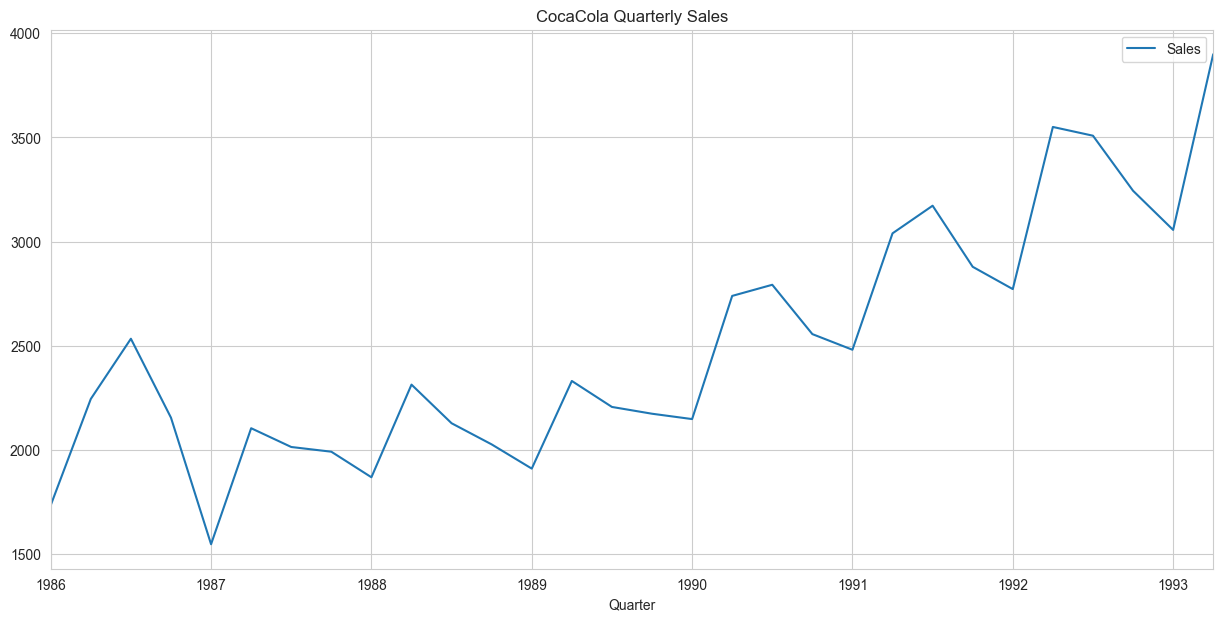

In [10]:
# visual analysis of TRAINING time series 
plt.figure(figsize=(15,7))
TRAIN.Sales.plot(kind='line',label='Sales')
plt.title('CocaCola Quarterly Sales')
plt.legend()
plt.show()

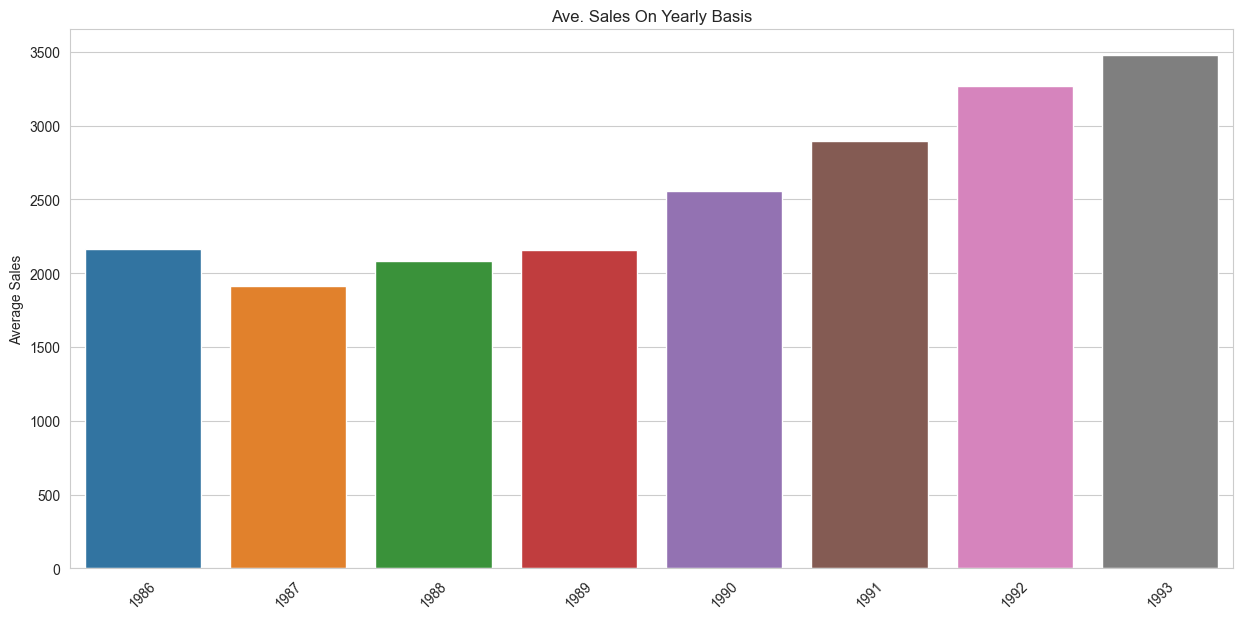

In [11]:
# In the begining Ave.sales were flat for 4 years
# but after 1988 sales increased steadily 
plt.figure(figsize=(15,7))
n = TRAIN.groupby(by=['year'])['Sales'].mean()
sns.barplot(x=n.index.ravel(),y=n.values.ravel())
plt.ylabel('Average Sales')
plt.title('Ave. Sales On Yearly Basis')
plt.xticks(rotation=45)
plt.show()

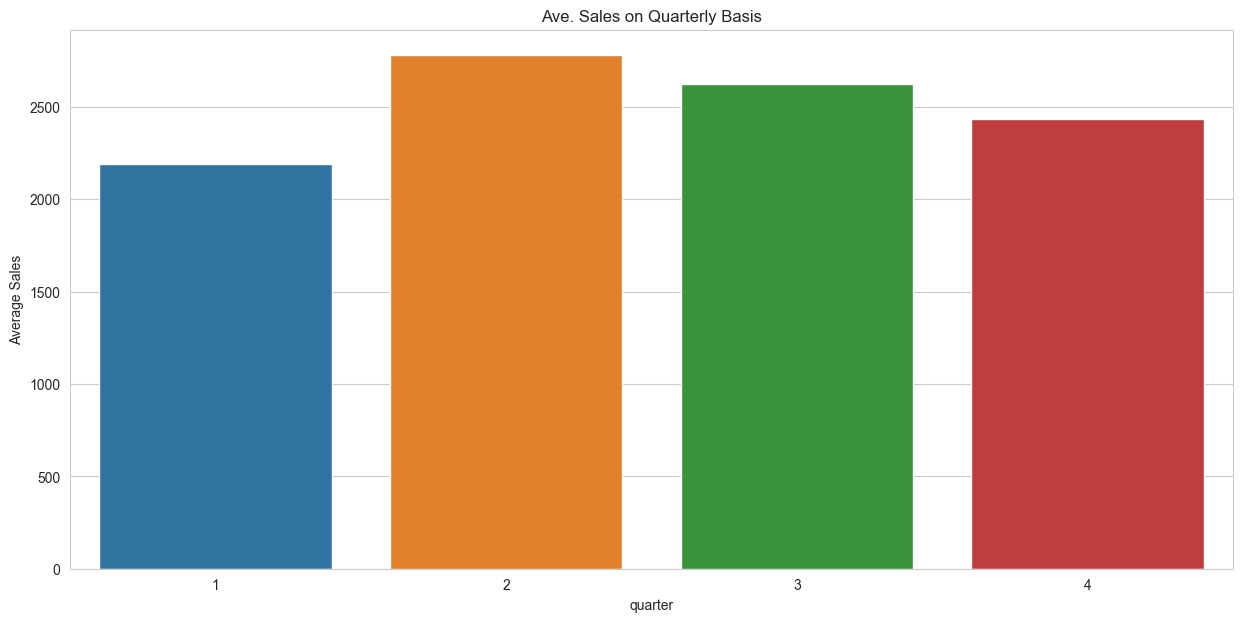

In [12]:
# Ave. sale is at peak in quarter 2 
plt.figure(figsize=(15,7))
n = TRAIN.groupby(by='quarter')['Sales'].mean()
sns.barplot(x=n.index,y=n.values.ravel())
plt.title('Ave. Sales on Quarterly Basis')
plt.ylabel('Average Sales')
plt.show()

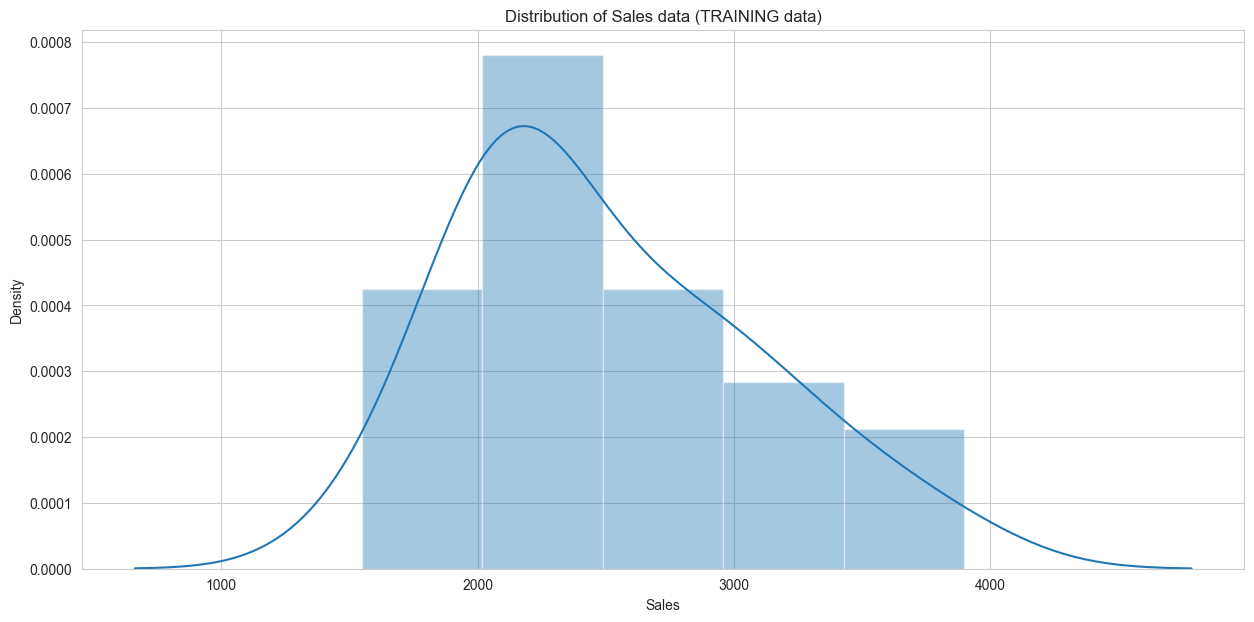

In [13]:
plt.figure(figsize=(15,7))
sns.distplot(TRAIN.Sales)
plt.title('Distribution of Sales data (TRAINING data)')
plt.show()

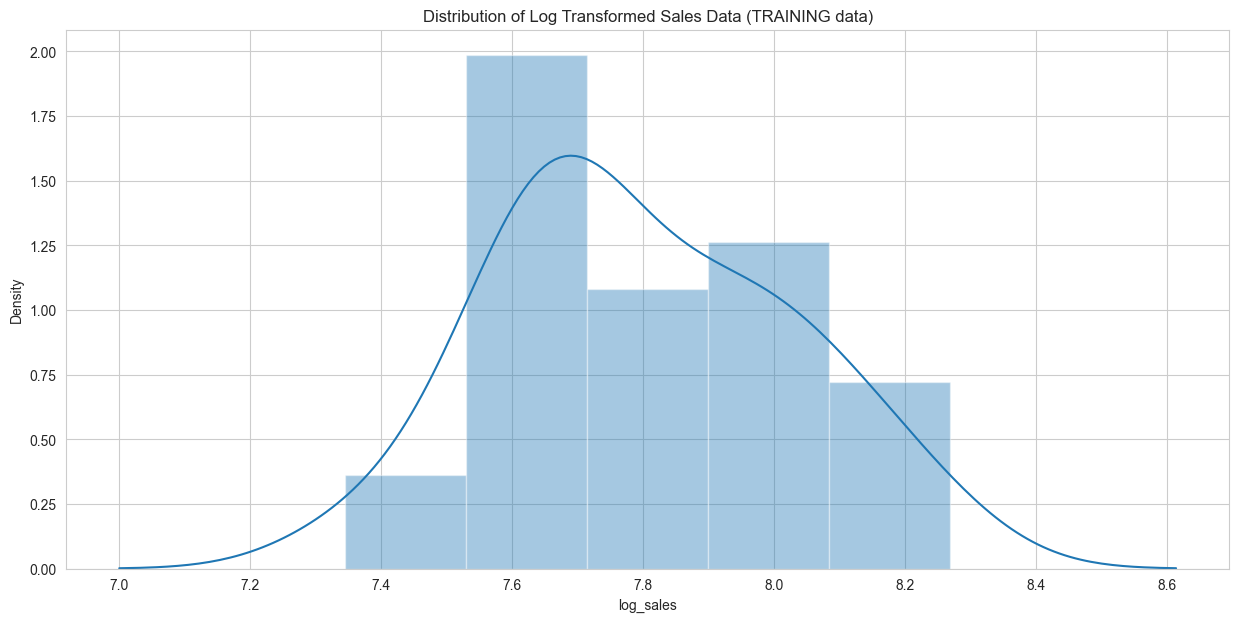

In [14]:
# applying 'log' transformation on 'sales' data 
# to reduce skewness 
TRAIN['log_sales'] = np.log(TRAIN.Sales).values.ravel()
# After 'log' transformation 
plt.figure(figsize=(15,7))
sns.distplot(TRAIN.log_sales)
plt.title('Distribution of Log Transformed Sales Data (TRAINING data)')
plt.show()

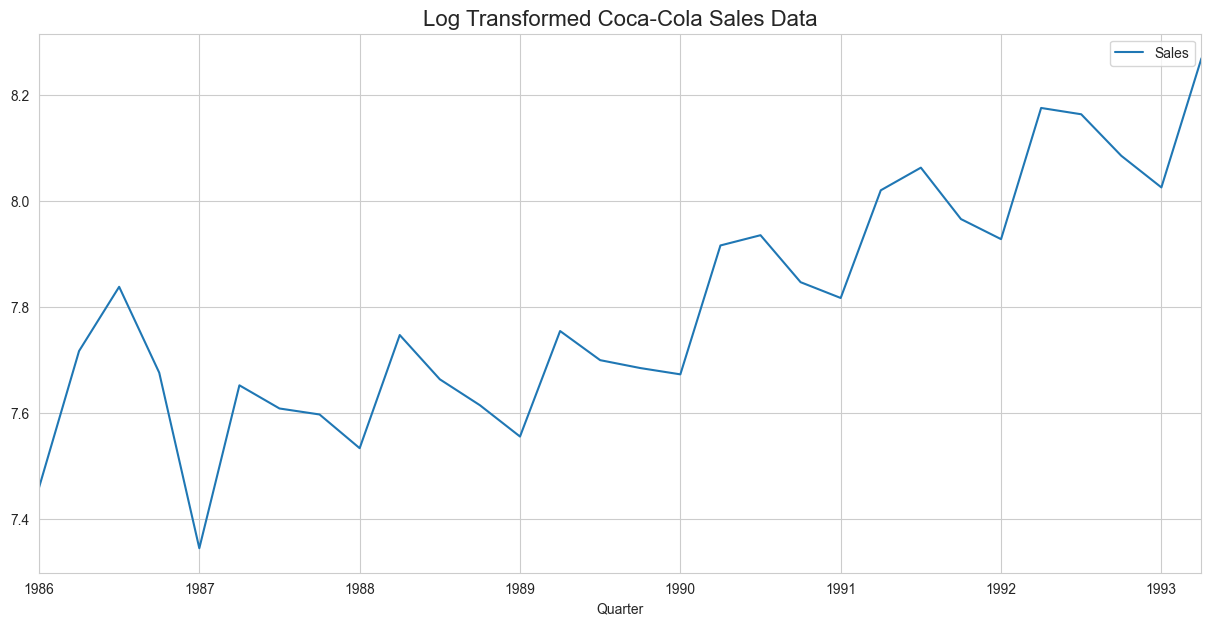

In [15]:
# visual analysis of log transformed time series 
plt.figure(figsize=(15,7))
TRAIN.log_sales.plot(kind='line',label='Sales')
plt.title('Log Transformed Coca-Cola Sales Data',fontsize=16)
plt.legend()
plt.show()

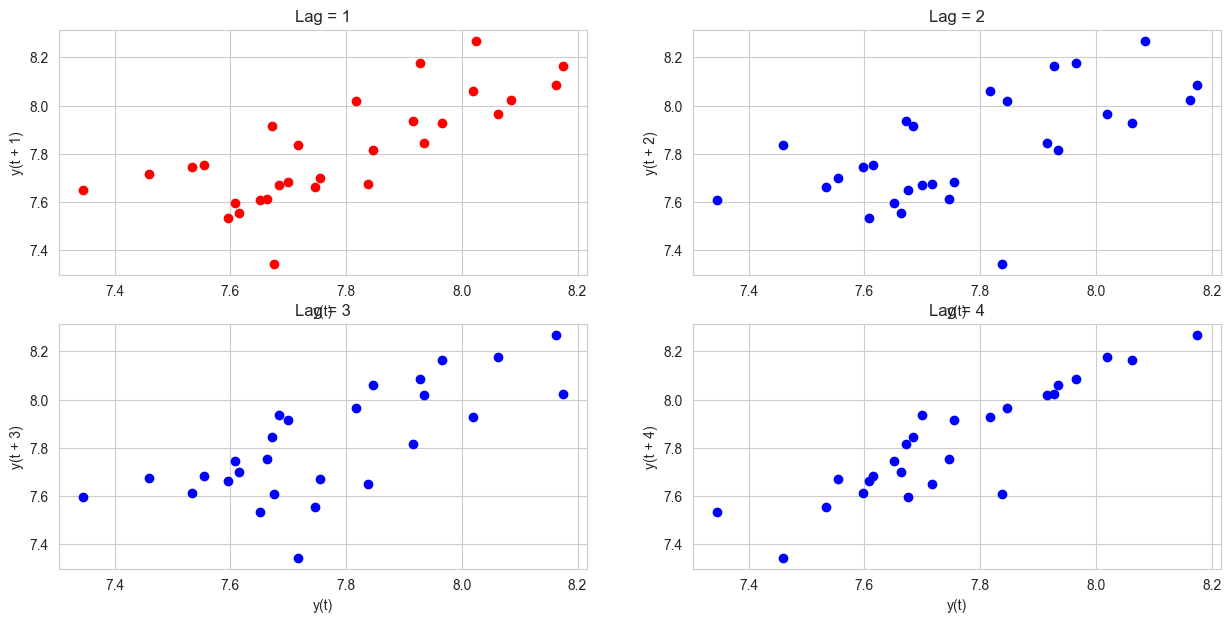

In [16]:
# Lag plots of 'log transformed sales data'
# There exists autocorrelation 
# Auto regression can be applied 
plt.figure(figsize=(15,7))
for k in range(1,5):
    plt.subplot(2,2,k)
    if k == 1:
        color = 'red'
    else :
        color = 'blue'
    pd.plotting.lag_plot(TRAIN.log_sales,lag=k,c=color)
    plt.title(f'Lag = {k}')
plt.show()

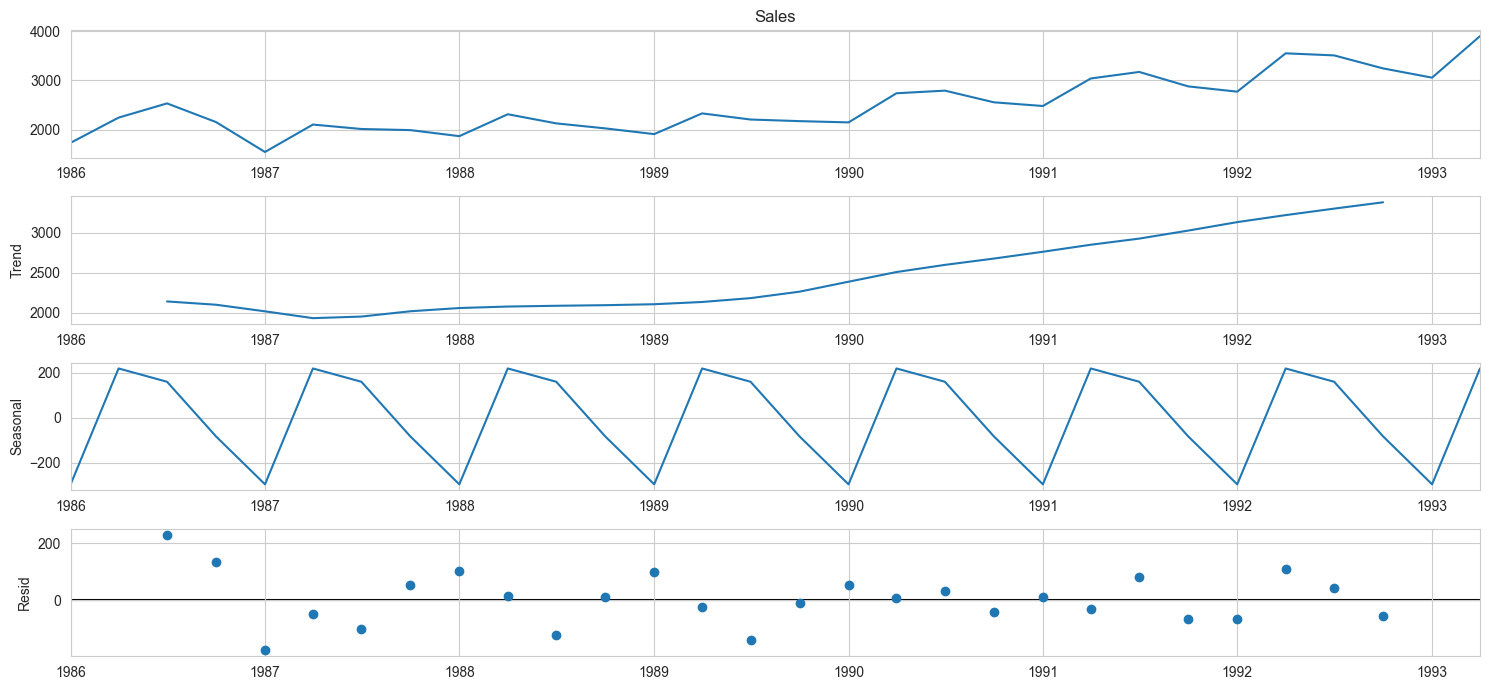

In [17]:
res = seasonal_decompose(TRAIN.Sales,model='additive').plot()
res.set_size_inches((15,7))
res.tight_layout()
plt.show()

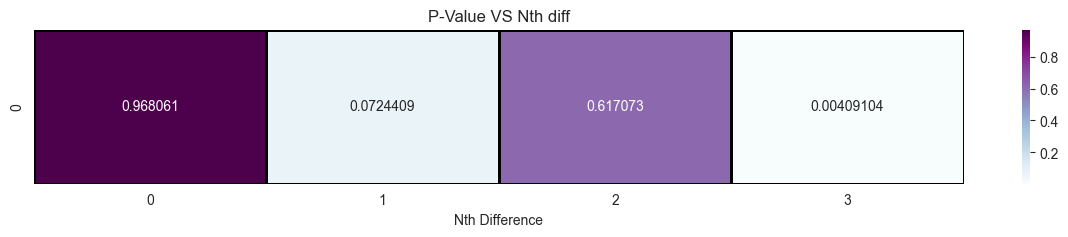

In [18]:
p_values = []
for i in range(4):
    if i > 0:
        emp = TRAIN.log_sales.values.ravel()
        for j in range(i):
            emp = emp[1:]-emp[:-1]
        p_values.append(adfuller(emp)[1])
    else :
        p_values.append(adfuller(TRAIN.log_sales.values.ravel())[1])
# 3rd order differencing makes time series stationary 
# becoz p_values < 0.05
# choosing value of 'I' as 3
plt.figure(figsize=(15,2))
sns.heatmap([p_values],
            linewidth=1,linecolor='black',
            cmap='BuPu',annot=True,fmt='g')
plt.xlabel('Nth Difference')
plt.title('P-Value VS Nth diff')
plt.show()

In [19]:
def RMSE(actual,predicted):
    rmse = np.square(np.subtract(actual.values.ravel(),
                                 predicted.values.ravel())).mean()
    return rmse

## NAIVE model

In [20]:
NaiveModel = ExponentialSmoothing(TRAIN.Sales).fit(smoothing_level=1)

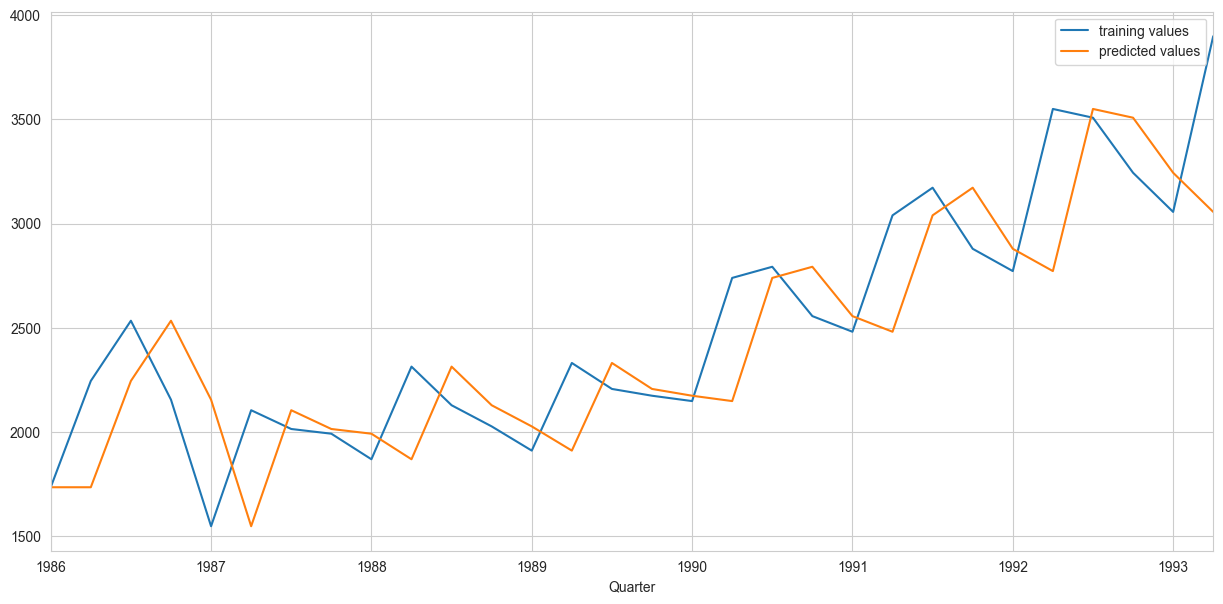

In [21]:
# forecasting on training data
plt.figure(figsize=(15,7))
TRAIN.Sales.plot(label='training values')
NaiveModel.predict(start=0).plot(label='predicted values')
plt.legend()
plt.show()

In [22]:
print(f'TRAINING RMSE : {round(RMSE(TRAIN.Sales,NaiveModel.predict(start=0))*100,4)} %')

TRAINING RMSE : 13009135.0799 %


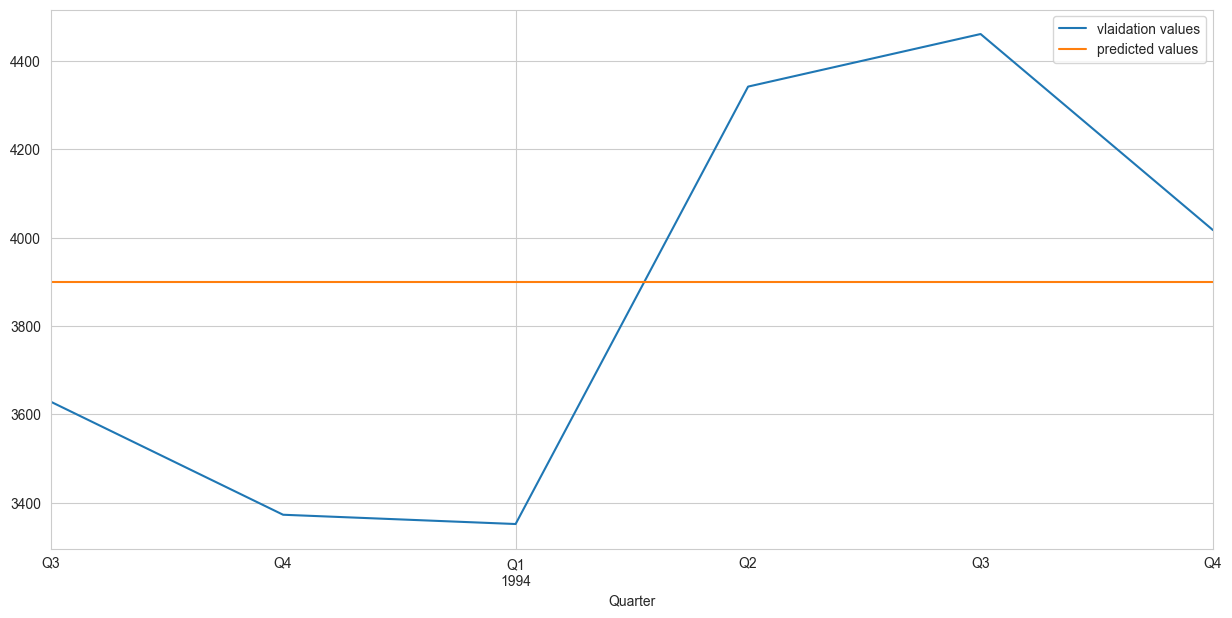

In [23]:
# forecasting on validation data 
plt.figure(figsize=(15,7))
VALID.Sales.plot(label='vlaidation values')
NaiveModel.forecast(6).plot(label='predicted values')
plt.legend()
plt.show()

In [24]:
print(f'VALIDATION RMSE : {round(RMSE(VALID.Sales,NaiveModel.forecast(6))*100,4)} %')

VALIDATION RMSE : 19580033.3333 %


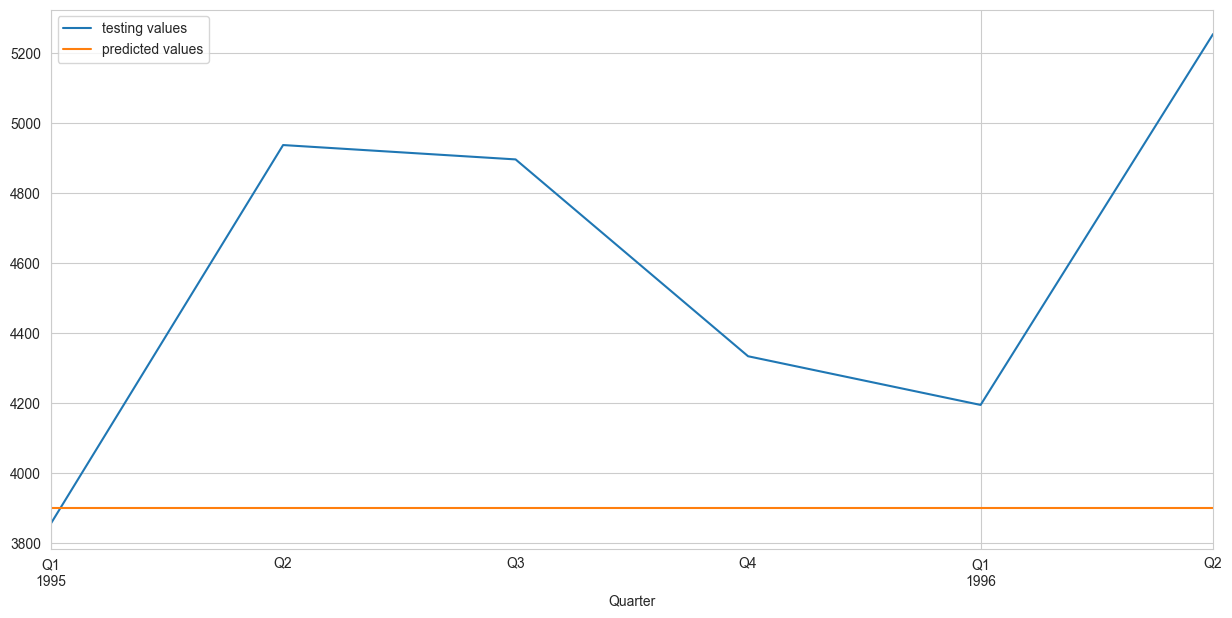

In [25]:
# forecasting on testing data 
plt.figure(figsize=(15,7))
TEST.Sales.plot(label='testing values')
NaiveModel.forecast(12)[6:].plot(label='predicted values')
plt.legend()
plt.show()

In [26]:
print(f'TESTING RMSE : {round(RMSE(TEST.Sales,NaiveModel.forecast(12)[6:])*100,4)} %')

TESTING RMSE : 69635116.6667 %


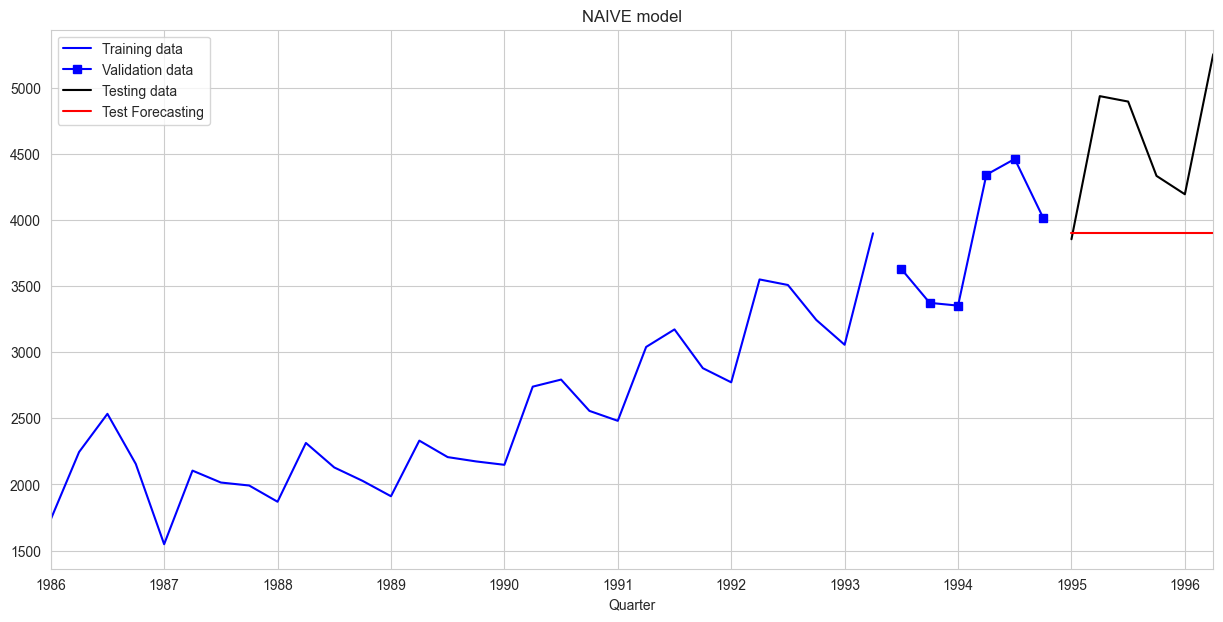

In [27]:
plt.figure(figsize=(15,7))
TRAIN.Sales.plot(color='blue',label='Training data')
VALID.Sales.plot(style='bs-',label='Validation data')
TEST.Sales.plot(color='black',label='Testing data')
NaiveModel.forecast(12)[6:].plot(color='red',
                                 label='Test Forecasting')
plt.legend()
plt.title('NAIVE model')
plt.show()

In [28]:
pd.DataFrame([['TRAINING',13009135.0799],
              ['VALIDATION',19580033.3333],
              ['TESTING',69635116.6667]],columns=['NAIVE','% RMSE'])

,NAIVE,% RMSE
0,TRAINING,1.300914e+07
1,VALIDATION,1.958003e+07
2,TESTING,6.963512e+07


## ARIMA model

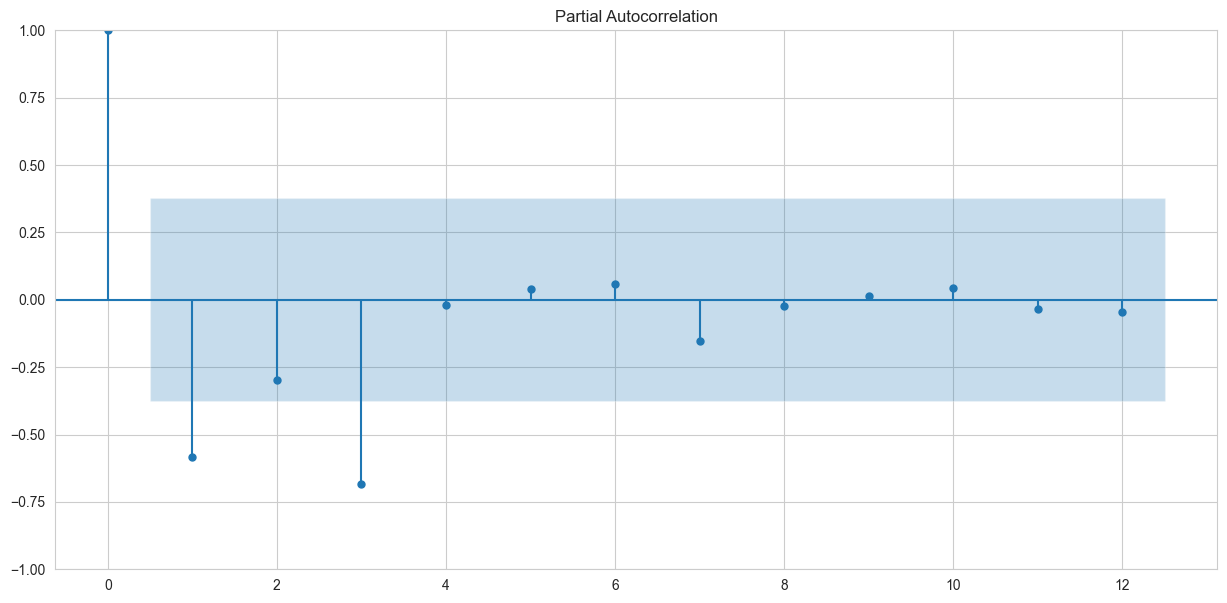

In [29]:
I = 3
emp = TRAIN.log_sales.values.ravel()
for i in range(I):
    emp = emp[1:]-emp[:-1]
res = plot_pacf(emp,method='ywm',lags=12)
res.set_size_inches((15,7))
plt.show()
# get 'P' values from pacf graph
P = [1,3]

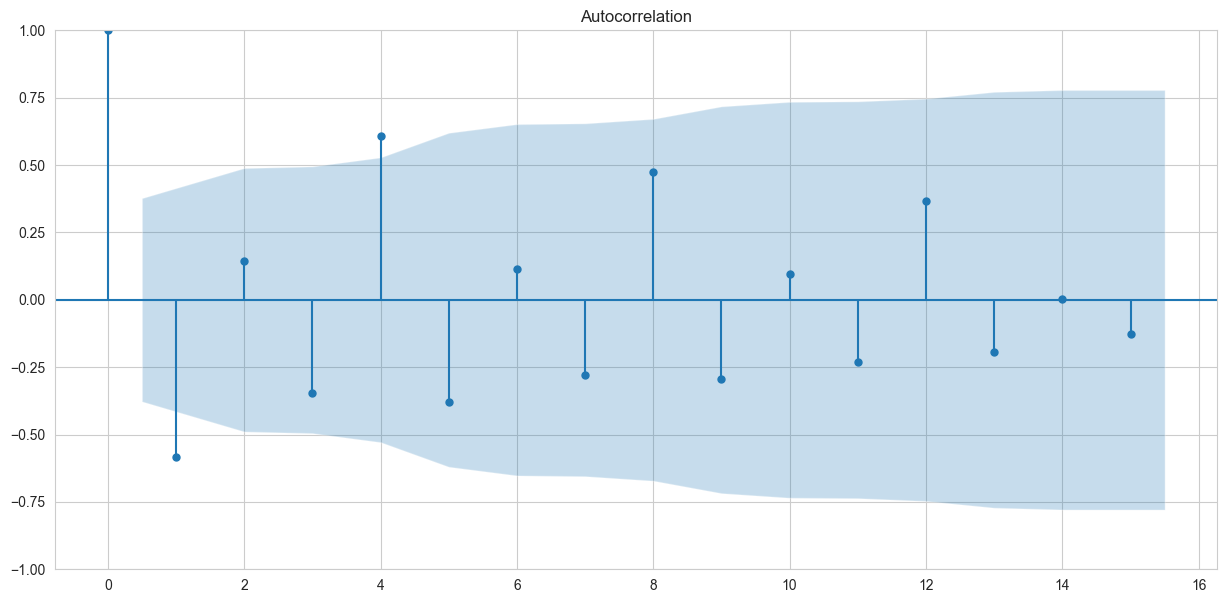

In [30]:
res = plot_acf(emp)
res.set_size_inches((15,7))
plt.show()
# get 'Q' values from acf graph
Q = [1,4]

In [31]:
print('Possible -> ')
print('Order for AR model : ',P)
print('Order for differencing : ',I)
print('Order for MA model : ',Q)

Possible -> 
Order for AR model :  [1, 3]
Order for differencing :  3
Order for MA model :  [1, 4]


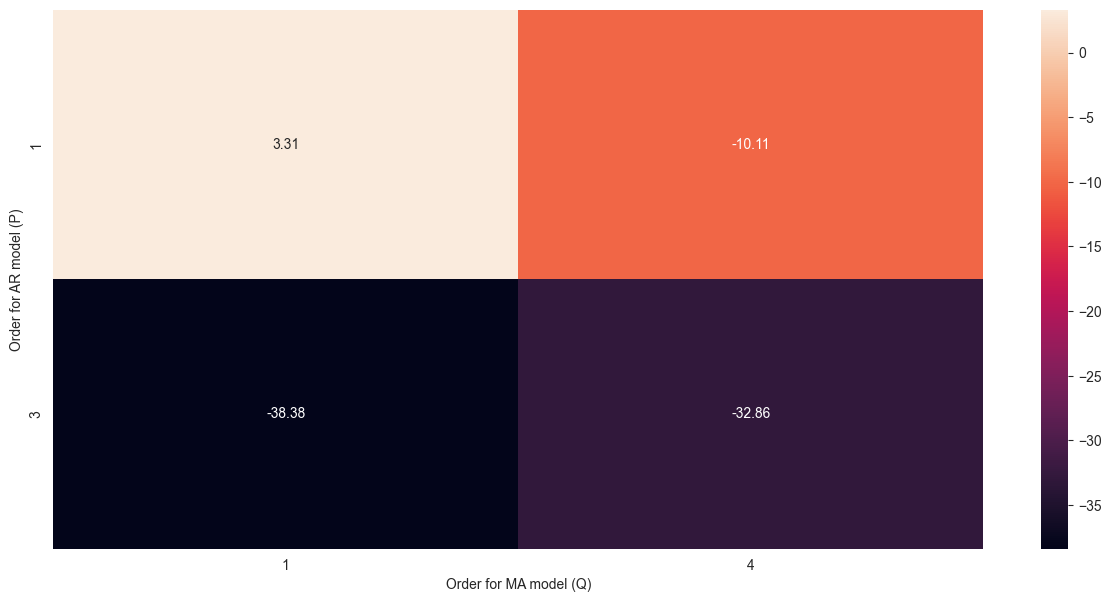

In [32]:
# Performing Grid Search over possible P,I,Q values
hold = []
for x in P:
    emp = []
    for y in Q:
        emp.append(round(ARIMA(TRAIN.log_sales,
                               order=(x,I,y)).fit().aic,2))
    hold.append(emp)
# grid search give lowest AIC values of -38.38
# at P = 3 and Q = 1
plt.figure(figsize=(15,7))
sns.heatmap(hold,annot=True,fmt='g',
            yticklabels=P,xticklabels=Q)
plt.xlabel('Order for MA model (Q)')
plt.ylabel('Order for AR model (P)')
plt.show()

In [33]:
order = (3,3,1)
print('Order of ARIMA : ',order)

Order of ARIMA :  (3, 3, 1)


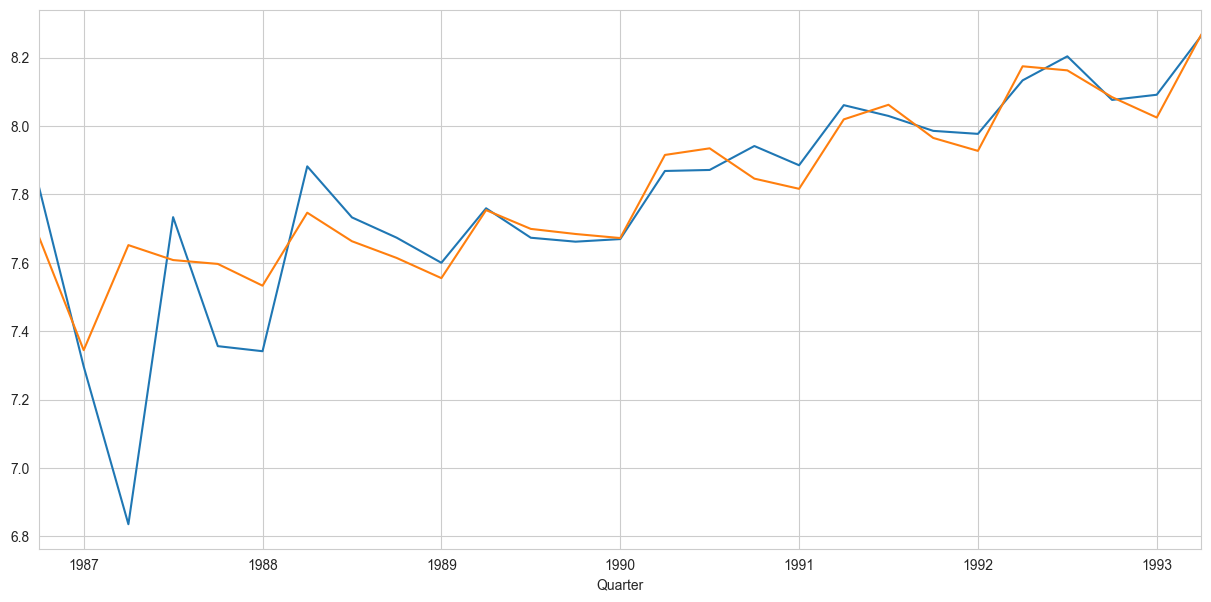

In [34]:
# forecasting on Training data 
plt.figure(figsize=(15,7))
ArimaModel = ARIMA(TRAIN.log_sales,order=order).fit()
ArimaModel.predict()[I:].plot()
TRAIN.log_sales[I:].plot()
plt.show()

In [35]:
print(f'TRAINING RMSE : {round(RMSE(TRAIN.log_sales[I:],ArimaModel.predict()[I:])*100,4)} %')

TRAINING RMSE : 3.1992 %


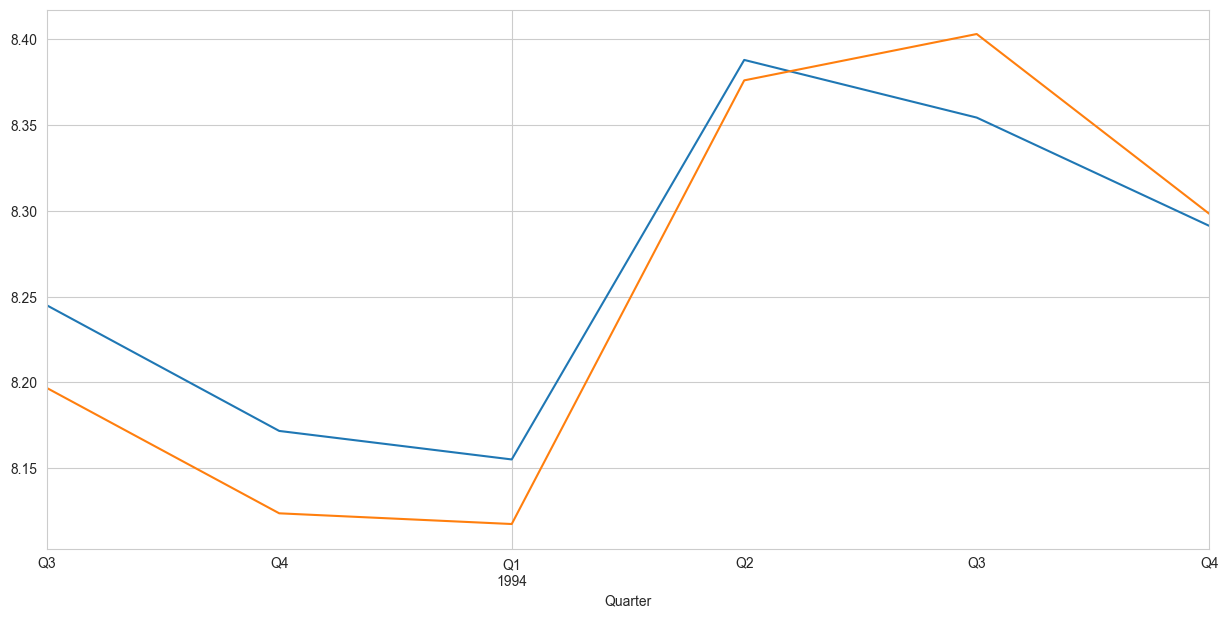

In [36]:
# forecasting on Validation data
plt.figure(figsize=(15,7))
ArimaModel.forecast(6).plot()
np.log(VALID.Sales).plot()
plt.show()

In [37]:
print(f'VALIDATION RMSE : {round(RMSE(np.log(VALID.Sales),ArimaModel.forecast(6))*100,4)} %')

VALIDATION RMSE : 0.1437 %


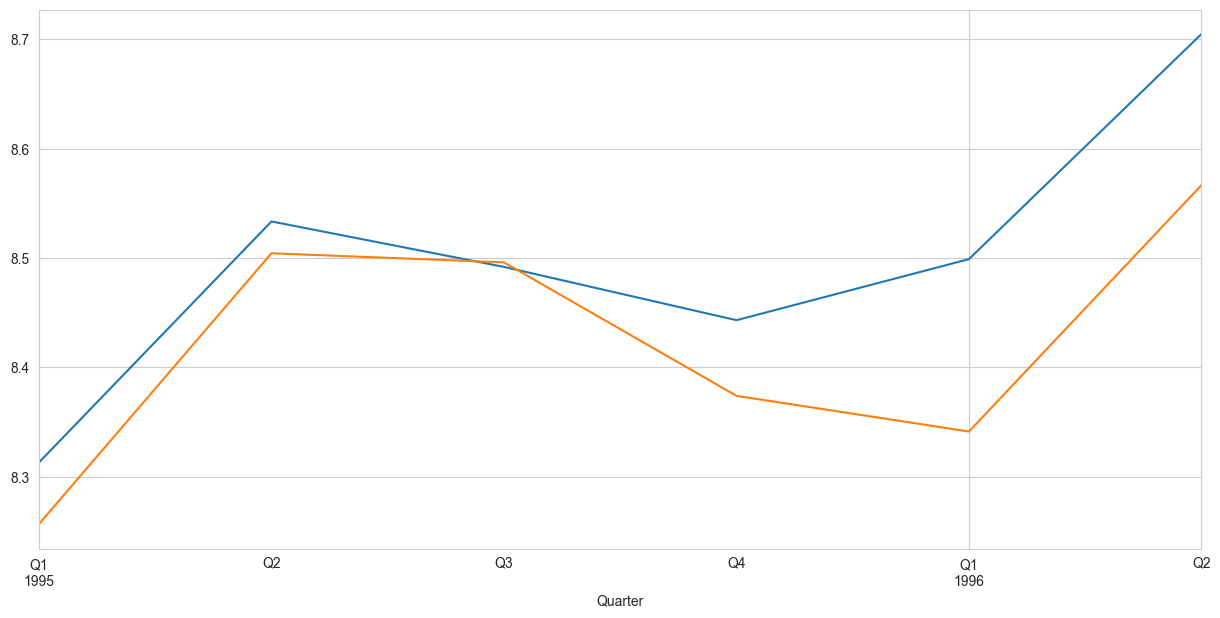

In [38]:
# forecasting on Testing data 
plt.figure(figsize=(15,7))
ArimaModel.forecast(12)[6:].plot()
np.log(TEST.Sales).plot()
plt.show()

In [39]:
print(f'TESTING RMSE : {round(RMSE(np.log(TEST.Sales),ArimaModel.forecast(12)[6:])*100,4)} %')

TESTING RMSE : 0.8783 %


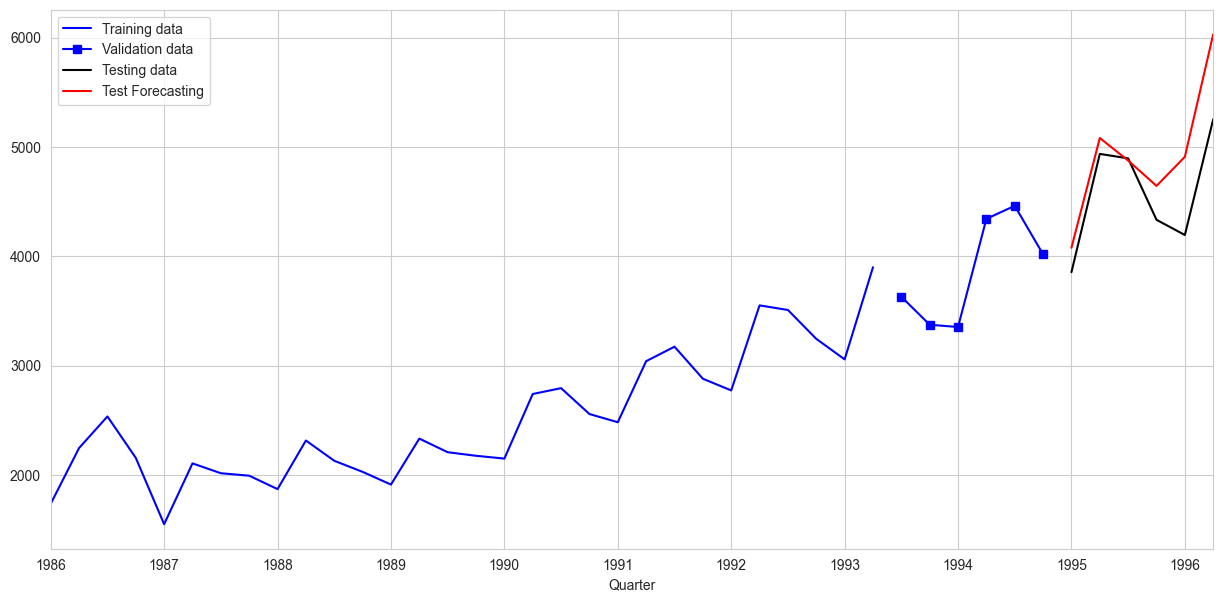

In [40]:
plt.figure(figsize=(15,7))
TRAIN.Sales.plot(color='blue',label='Training data')
VALID.Sales.plot(style='bs-',label='Validation data')
TEST.Sales.plot(color='black',label='Testing data')
(np.e**(ArimaModel.forecast(12)[6:])).plot(color='red',
                                           label='Test Forecasting')
plt.legend()
plt.show()

In [41]:
pd.DataFrame([['TRAINING',3.1992],
              ['VALIDATION',0.1437],
              ['TESTING',0.8783]],columns=['ARIMA','% RMSE'])

,ARIMA,% RMSE
0,TRAINING,3.1992
1,VALIDATION,0.1437
2,TESTING,0.8783


## SARIMA model

In [51]:
# seasonal difference of 4 quarters
samp = TRAIN.copy(deep=True)
samp = TRAIN.diff(4).dropna()
M = 4

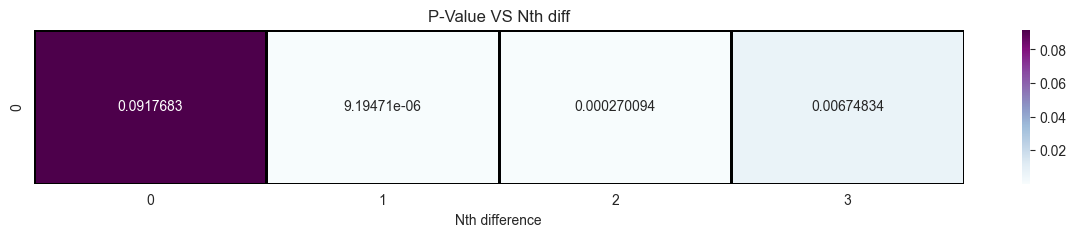

In [44]:
p_values = []
for i in range(4):
    if i > 0:
        emp = samp.log_sales.values.ravel()
        for j in range(i):
            emp = emp[1:]-emp[:-1]
        p_values.append(adfuller(emp)[1])
    else :
        p_values.append(adfuller(samp.log_sales.values.ravel())[1])
# 1st order differencing makes time series stationary 
# becoz p_value < 0.05 
# choosing value of 'Is' as 1
plt.figure(figsize=(15,2))
sns.heatmap([p_values],
            linewidth=1,linecolor='black',
            cmap='BuPu',annot=True,fmt='g')
plt.xlabel('Nth difference')
plt.title('P-Value VS Nth diff')
plt.show()

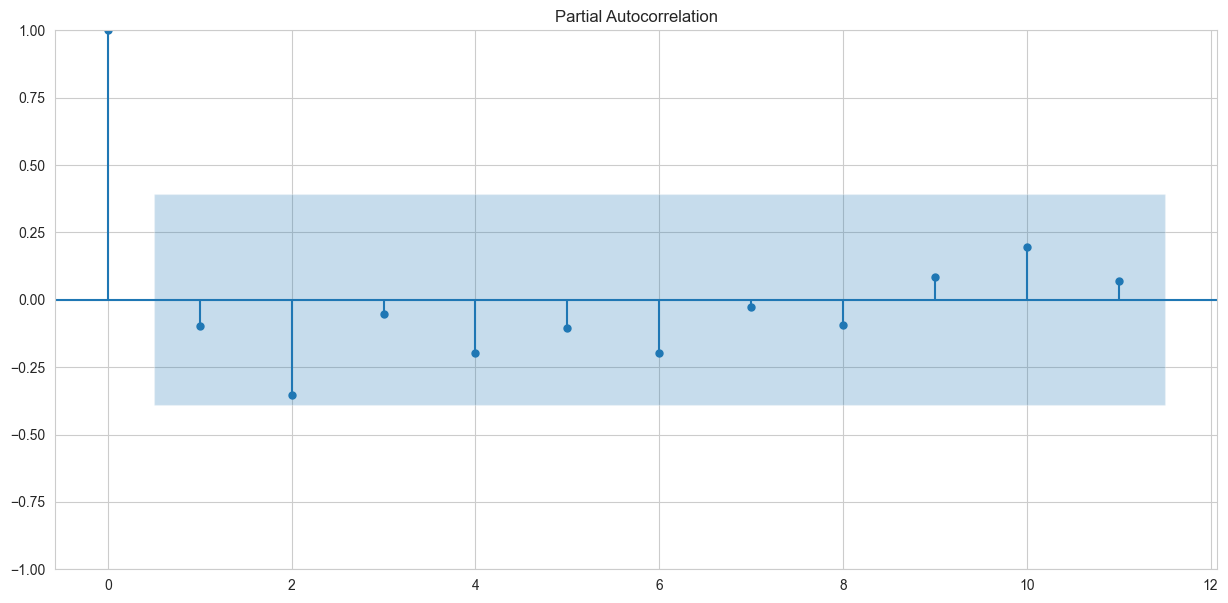

In [47]:
Is = 1
emp = samp.log_sales.values.ravel()
for i in range(Is):
    emp = emp[1:]-emp[:-1]
res = plot_pacf(emp,lags=11,method='ywm')
res.set_size_inches((15,7))
plt.show()
# get 'Ps' values from pacf graph
Ps = 0

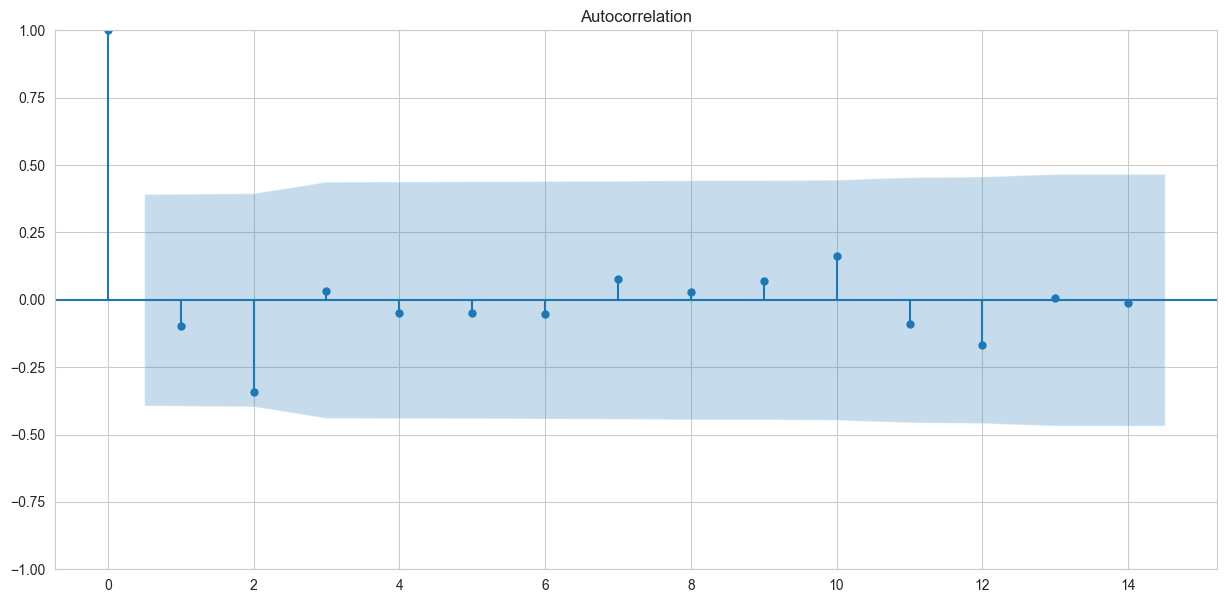

In [49]:
res = plot_acf(emp)
res.set_size_inches((15,7))
plt.show()
# get 'Qs' value from acf graph 
Qs = 0

In [52]:
print('Possible -> ')
print('Seasonal order for AR model : ',Ps)
print('Seasonal order for differencing : ',Is)
print('Seasonal order for MA model : ',Qs)
print('Seasonal order for seasonal differencing : ',M)

Possible -> 
Seasonal order for AR model :  0
Seasonal order for differencing :  1
Seasonal order for MA model :  0
Seasonal order for seasonal differencing :  4


In [53]:
seasonal_order = (Ps,Is,Qs,M)
print('Order of ARIMA : ',order)
print('Order of SARIMA : ',seasonal_order)

Order of ARIMA :  (3, 3, 1)
Order of SARIMA :  (0, 1, 0, 4)


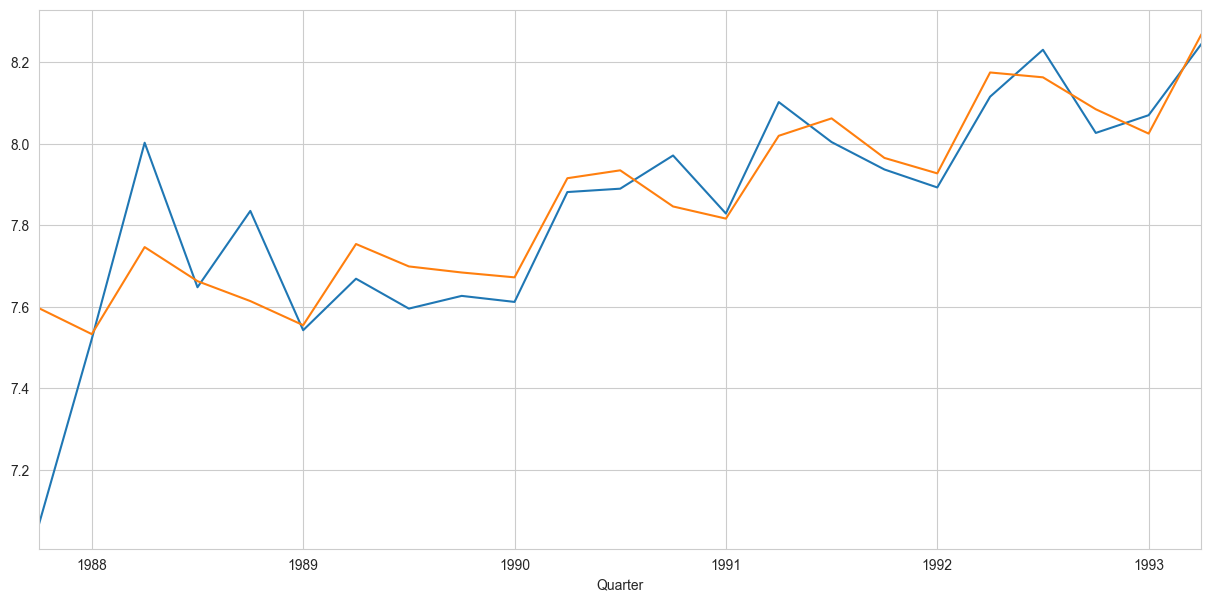

In [57]:
# forecasting on Training data
plt.figure(figsize=(15,7))
SarimaModel = SARIMAX(TRAIN.log_sales,order=order,
                      seasonal_order=seasonal_order).fit()
SarimaModel.predict()[3+M:].plot()
TRAIN.log_sales[3+M:].plot()
plt.show()

In [58]:
print(f'TRAINING RMSE : {round(RMSE(TRAIN.log_sales[3+M:],SarimaModel.predict()[3+M:])*100,4)} %')

TRAINING RMSE : 2.0234 %


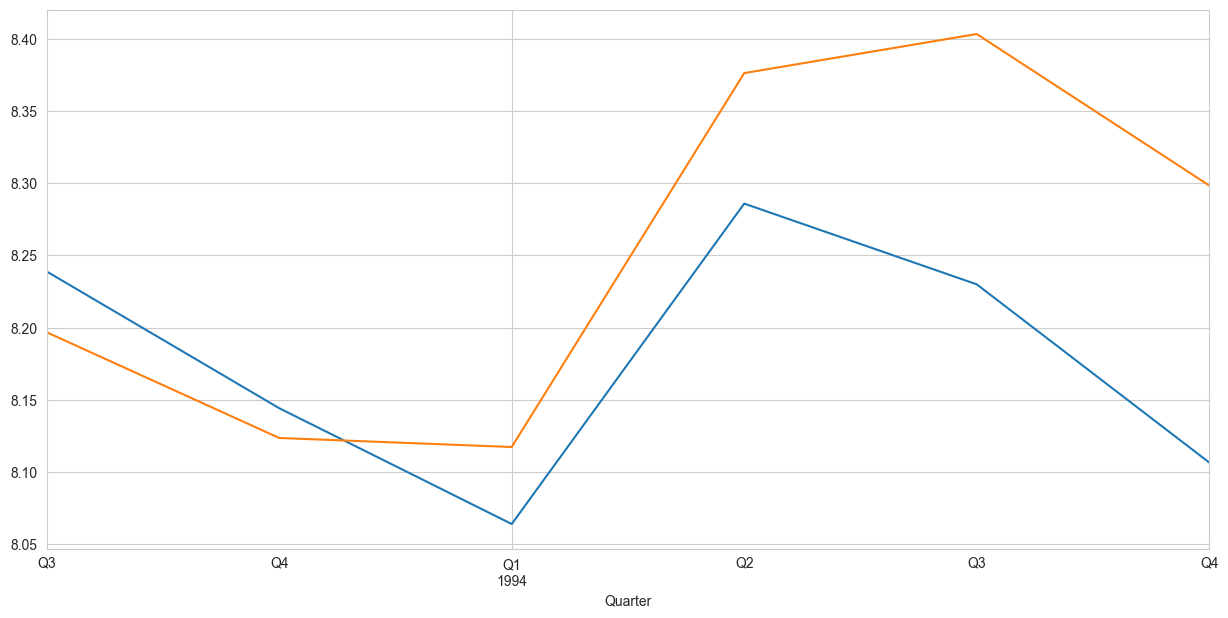

In [62]:
# forecasting on validation data
plt.figure(figsize=(15,7))
SarimaModel.forecast(6).plot()
np.log(VALID.Sales).plot()
plt.show()

In [64]:
print(f'VALIDATION RMSE : {round(RMSE(np.log(VALID.Sales),SarimaModel.forecast(6))*100,4)} %')

VALIDATION RMSE : 1.3324 %


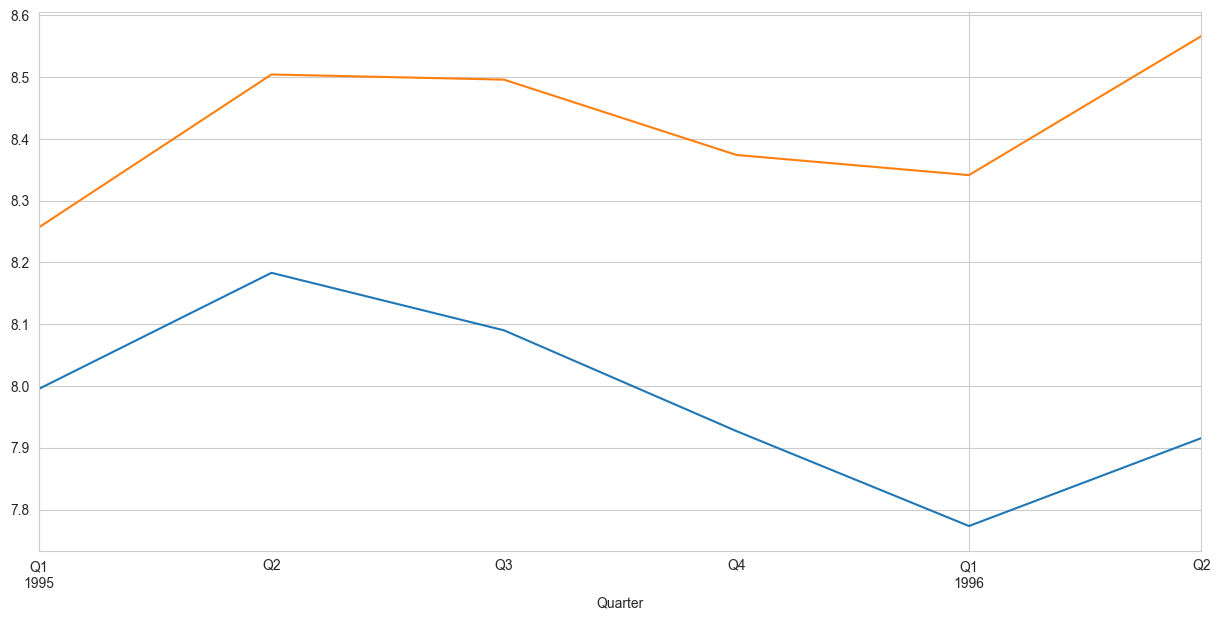

In [65]:
# forecasting on Testing data
plt.figure(figsize=(15,7))
SarimaModel.forecast(12)[6:].plot()
np.log(TEST.Sales).plot()
plt.show()

In [66]:
print(f'TESTING RMSE : {round(RMSE(np.log(TEST.Sales),SarimaModel.forecast(12)[6:])*100,4)} %')

TESTING RMSE : 21.372 %


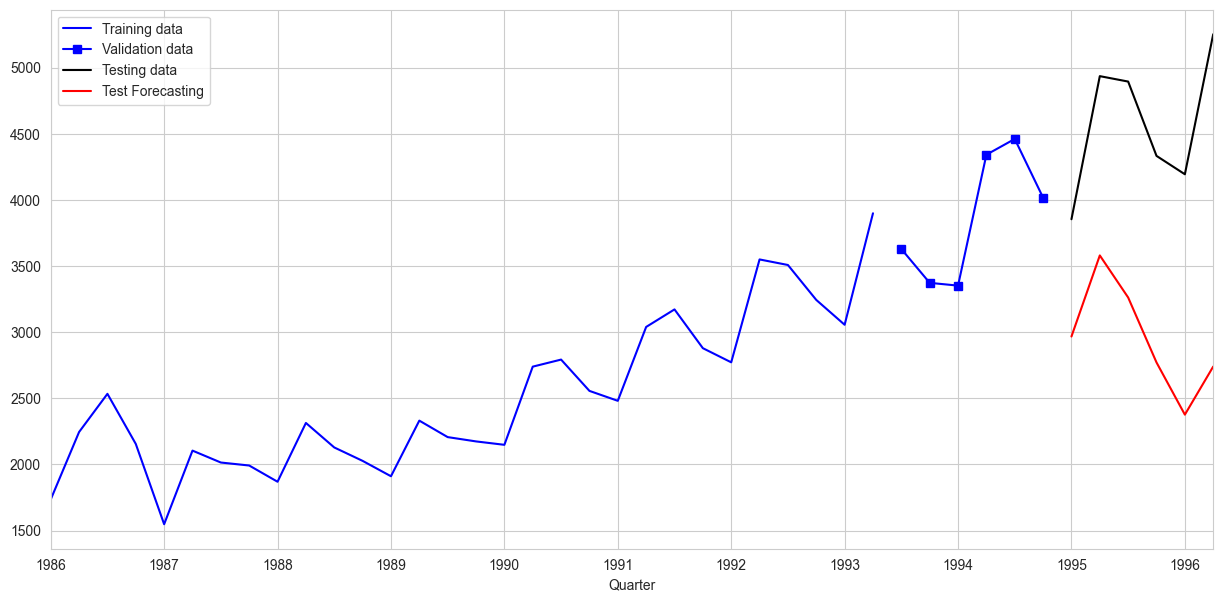

In [67]:
plt.figure(figsize=(15,7))
TRAIN.Sales.plot(color='blue',label='Training data')
VALID.Sales.plot(style='bs-',label='Validation data')
TEST.Sales.plot(color='black',label='Testing data')
(np.e**(SarimaModel.forecast(12)[6:])).plot(color='red',
                                            label='Test Forecasting')
plt.legend()
plt.show()

In [109]:
pd.DataFrame([['TRAINING',2.0234],
              ['VALIDATION',1.3324],
              ['TESTING',21.372]],columns=['SARIMA','% RMSE'])

,SARIMA,% RMSE
0,TRAINING,2.0234
1,VALIDATION,1.3324
2,TESTING,21.3720


## HOLT-WINTERS smoothing

In [87]:
HoltWintModel = ExponentialSmoothing(TRAIN.Sales,
                             trend='mul',
                             seasonal='add',
                             seasonal_periods=4).fit()

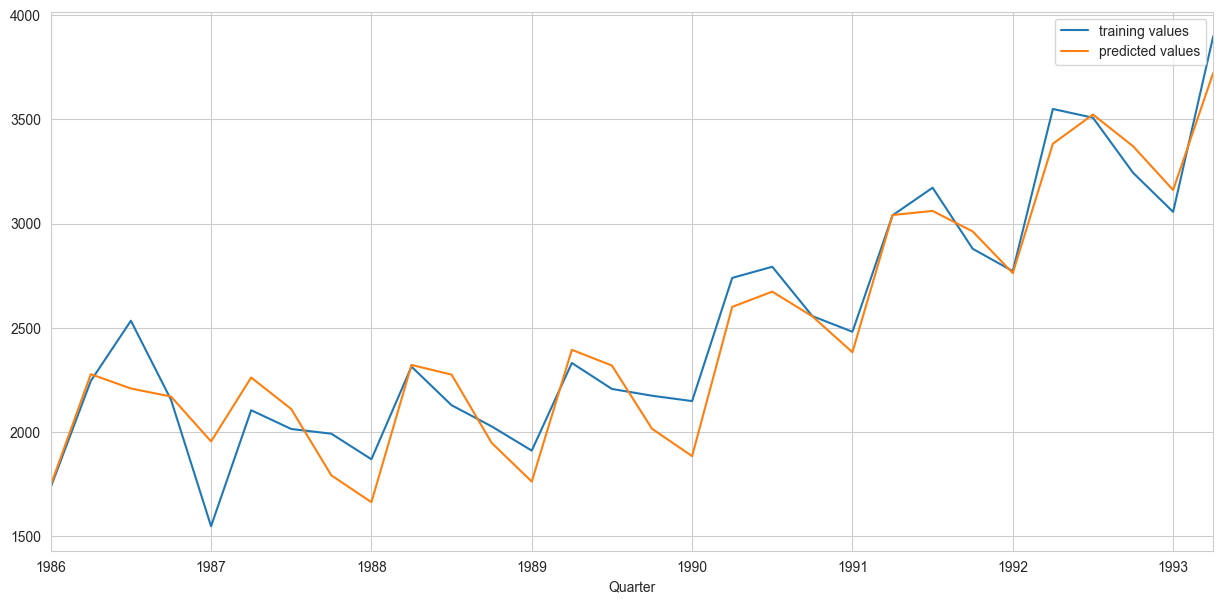

In [88]:
# forecasting on training data 
plt.figure(figsize=(15,7))
TRAIN.Sales.plot(label='training values')
HoltWintModel.predict(start=0).plot(label='predicted values')
plt.legend()
plt.show()

In [96]:
print(f'TRAINING RMSE : {round(RMSE(TRAIN.Sales,HoltWintModel.predict(start=0))*100,4)} %')

TRAINING RMSE : 2330702.1905 %


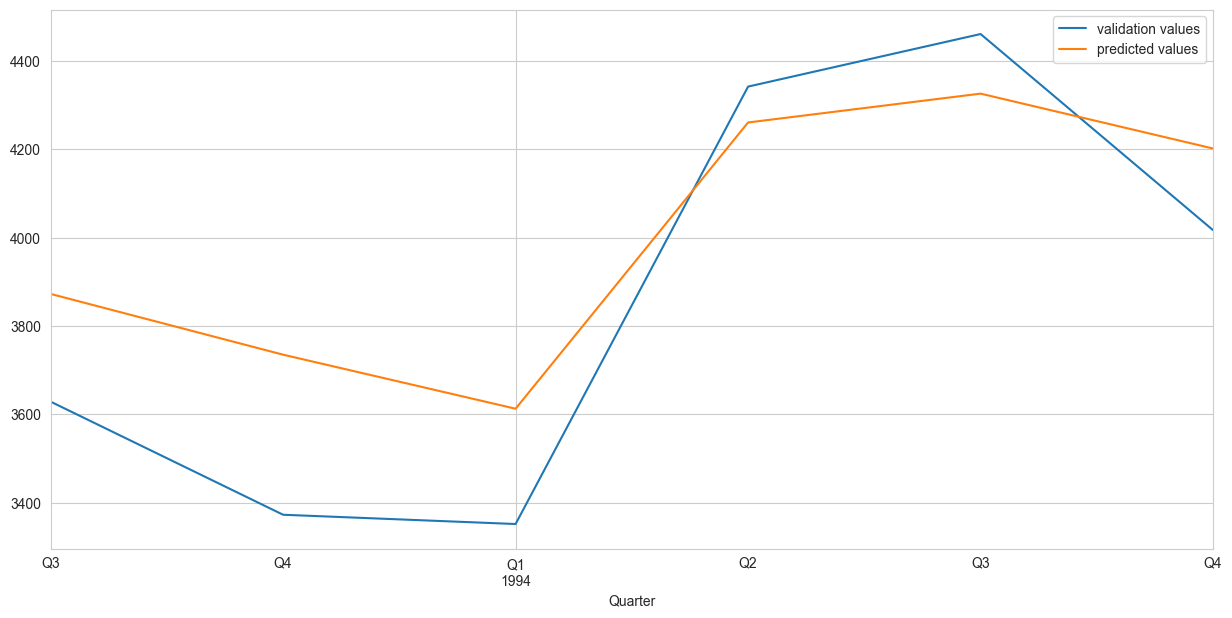

In [102]:
# forecasting on validation data 
plt.figure(figsize=(15,7))
VALID.Sales.plot(label='validation values')
HoltWintModel.forecast(6).plot(label='predicted values')
plt.legend()
plt.show()

In [103]:
print(f'VALIDATION RMSE : {round(RMSE(VALID.Sales,HoltWintModel.forecast(6))*100,4)} %')

VALIDATION RMSE : 5295550.4725 %


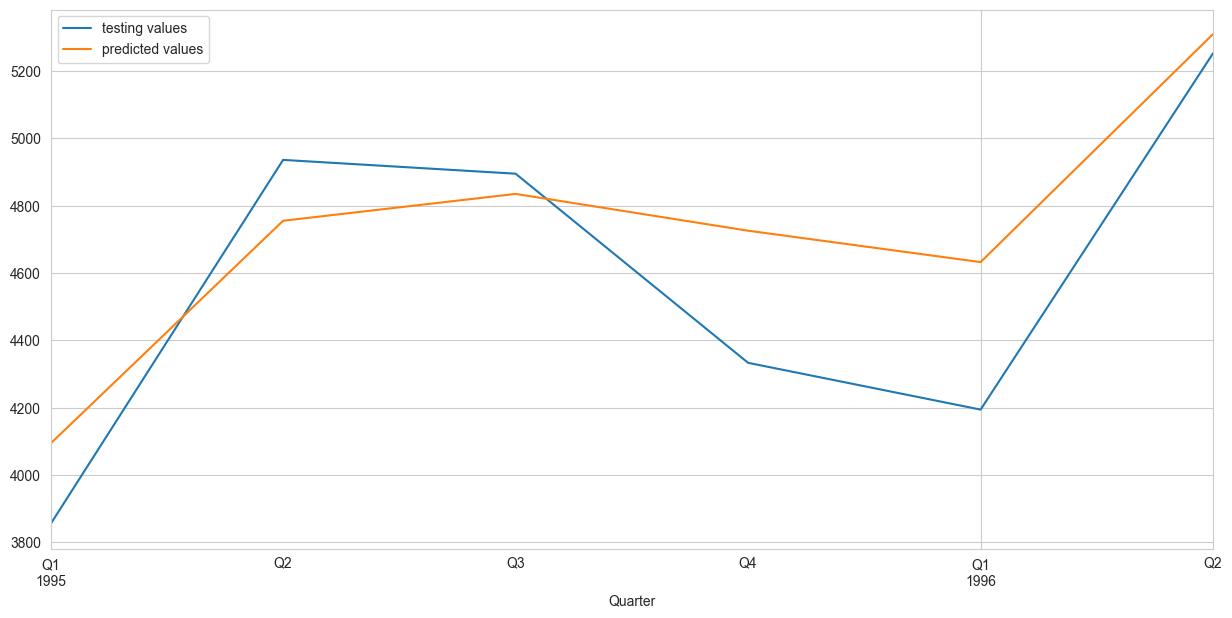

In [104]:
# forecasting on testing data 
plt.figure(figsize=(15,7))
TEST.Sales.plot(label='testing values')
HoltWintModel.forecast(12)[6:].plot(label='predicted values')
plt.legend()
plt.show()

In [106]:
print(f'TESTING RMSE : {round(RMSE(TEST.Sales,HoltWintModel.forecast(12)[6:])*100,4)} %')

TESTING RMSE : 7384394.9219 %


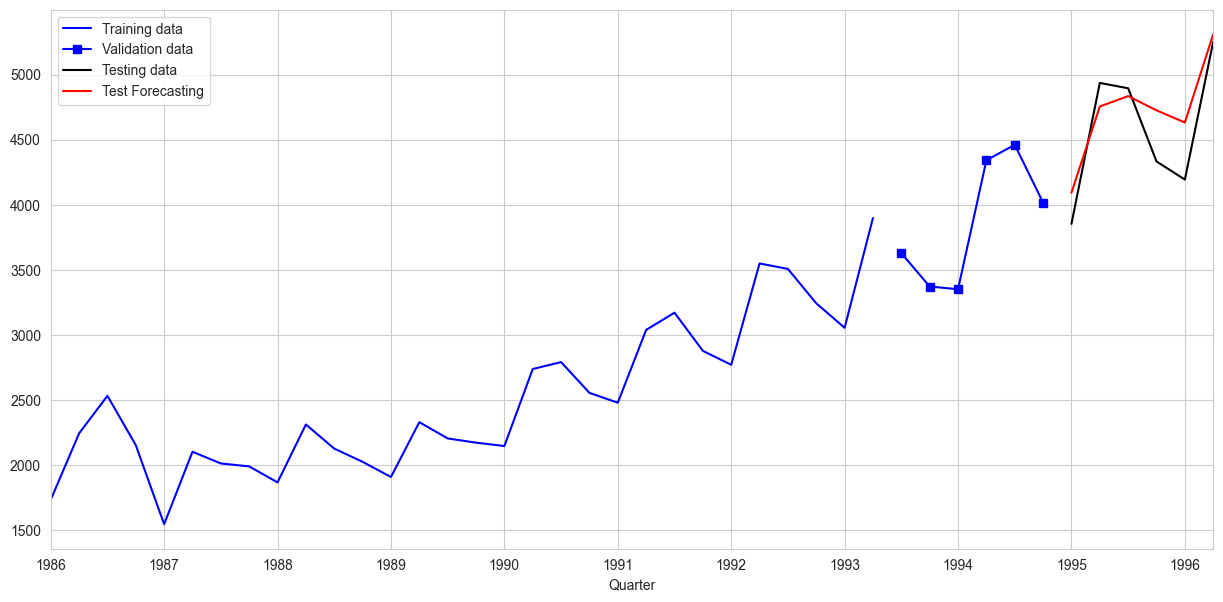

In [111]:
plt.figure(figsize=(15,7))
TRAIN.Sales.plot(color='blue',label='Training data')
VALID.Sales.plot(style='bs-',label='Validation data')
TEST.Sales.plot(color='black',label='Testing data')
HoltWintModel.forecast(12)[6:].plot(color='red',
                                   label='Test Forecasting')
plt.legend()
plt.show()

In [108]:
pd.DataFrame([['TRAINING',2330702.1905],
              ['VALIDATION',5295550.4725],
              ['TESTING',7384394.9219]],columns=['HOLT WINTER','% RMSE'])

,HOLT WINTER,% RMSE
0,TRAINING,2.330702e+06
1,VALIDATION,5.295550e+06
2,TESTING,7.384395e+06
